## Classification with Python

Hopefully now you are feeling a bit more comfortable with Python, Kaggle, and modeling. 

The next kaggle project:

https://www.kaggle.com/c/costa-rican-household-poverty-prediction

### Grading

This homework is due **Nov. 06, 2018 by 4:00pn Utah time.** By that time, you need to have committed all your code to your github and submitted a link to your work to the TA. We can see on your Github account when you last committed code. :)

Rubric:

* Code Quality - 10%
* Storytelling - 10%
* Result on Kaggle - 5%
* Describing, Cleaning, and Visualizing data - 25%
* Modeling - 50%

More specifically, for modeling we will look for: 

* Model Selection: Did you try multiple models? Why did you choose these models? How do they work? What are they assumptions? And how did you test/account for them? How did you select hyper-parameters?
* Model evaluation: Did you evaluate your model on multiple metrics? Where does your model do well? Where could it be improved? How are the metrics different?
* Model interpretation: What do the model results tell you? Which variables are important? High bias or variance and how did you / could you fix this? How confident are you in your results? 
* Model usefulness: Do you think your final model was useful? If so, how would you recommend using it? Convince us, that if we were a company, we would feel comfortable using your model with our users. Think about edge cases as well - are there certain areas that the model performs poorly on? Best on? How would you handle these cases, if say Zillow wanted to leverage your model realizing that bad recommendations on sale prices would hurt customer trust and your brand. This section also falls into the storytelling aspect of the grading.

In [53]:
# normal imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
# cleaning imports
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler, RobustScaler
# model imports
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV, ElasticNet, Lasso,  BayesianRidge, SGDRegressor, LassoLars
import xgboost
from sklearn.isotonic import IsotonicRegression
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
#import lightgbm
# validation imports
from sklearn.metrics import mean_squared_error, classification_report, roc_auc_score
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV

# Get the data all spic and span ready

In [31]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")


In [32]:
# wanna keep that ID
train_ID = train['Id']
test_ID = test['Id']
#train = train_.drop('Id', 1).copy()
#test = test.drop('Id', 1).copy()
y = train['Target']

In [33]:
# let's gander at the data
y.describe()

count    9557.000000
mean        3.302292
std         1.009565
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         4.000000
Name: Target, dtype: float64

In [34]:
# It seems 4 is an overwhelming majority but let's see how much
y.value_counts(normalize=True)

4    0.627394
2    0.167103
3    0.126504
1    0.079000
Name: Target, dtype: float64

(array([   0.,  755., 1597., 1209., 5996.,    0.]),
 array([0, 1, 2, 3, 4, 5, 6]),
 <a list of 6 Patch objects>)

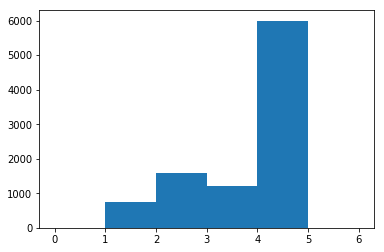

In [35]:
# let's look at the disparity
plt.hist(y, bins=[0,1,2,3,4,5,6])

In [36]:
# lets see what's super correlated
abs(train.corr()['Target']).sort_values(ascending=False)
train = train.drop('Target', 1).copy()
# notice I used absolute value because negative correlation matters jsut as much as positive

In [37]:
# put both test and training data together
all_ = pd.concat((train, test), sort=True)
#all_ = all_.drop('Id', 1).copy()

In [38]:
# count the nans
all_.isnull().sum().sum()

77384

In [39]:
# see which columns have NaN
all_.isnull().sum()

Id                     0
SQBage                 0
SQBdependency          0
SQBedjefe              0
SQBescolari            0
SQBhogar_nin           0
SQBhogar_total         0
SQBmeaned             36
SQBovercrowding        0
abastaguadentro        0
abastaguafuera         0
abastaguano            0
age                    0
agesq                  0
area1                  0
area2                  0
bedrooms               0
cielorazo              0
computer               0
coopele                0
dependency             0
dis                    0
edjefa                 0
edjefe                 0
elimbasu1              0
elimbasu2              0
elimbasu3              0
elimbasu4              0
elimbasu5              0
elimbasu6              0
                   ...  
r4m1                   0
r4m2                   0
r4m3                   0
r4t1                   0
r4t2                   0
r4t3                   0
refrig                 0
rez_esc            27581
rooms                  0


In [40]:
# lets jsut drop the ones with Nulls
for i in all_:
    if all_[i].isnull().sum() != 0:
        print(i)
        all_ = all_.drop(f"{i}", 1).copy()
        #test = test.drop(f'{i}', 1).copy()

SQBmeaned
meaneduc
rez_esc
v18q1
v2a1


In [41]:
# see if we got em all
all_.isnull().sum().sum()

0

In [43]:
# would you look at that, nothing is crazy correlated so we can go ahead and save this as X
all_ = pd.get_dummies(all_)
#X = train.drop(['Target'], 1).copy()
X_train = all_[:train.shape[0]]
X_test = all_[train.shape[0]:]

# Random Forest

In [44]:
# lets do an initial random forest 
param_dictionary = {'n_estimators':[100,200,300,400,500], 'max_depth':[2,3,4]}
RFC = RandomForestClassifier(n_jobs=-1, class_weight='balanced')#, max_depth=3)
gs1 = GridSearchCV(RFC, param_dictionary, n_jobs=1, verbose=2, cv=2)
gs1.fit(X_train,y)

Fitting 2 folds for each of 15 candidates, totalling 30 fits
[CV] max_depth=2, n_estimators=100 ...................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................... max_depth=2, n_estimators=100, total=  11.2s
[CV] max_depth=2, n_estimators=100 ...................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   13.3s remaining:    0.0s


[CV] .................... max_depth=2, n_estimators=100, total=   7.7s
[CV] max_depth=2, n_estimators=200 ...................................
[CV] .................... max_depth=2, n_estimators=200, total=   8.0s
[CV] max_depth=2, n_estimators=200 ...................................
[CV] .................... max_depth=2, n_estimators=200, total=   8.0s
[CV] max_depth=2, n_estimators=300 ...................................
[CV] .................... max_depth=2, n_estimators=300, total=   8.4s
[CV] max_depth=2, n_estimators=300 ...................................
[CV] .................... max_depth=2, n_estimators=300, total=   9.7s
[CV] max_depth=2, n_estimators=400 ...................................
[CV] .................... max_depth=2, n_estimators=400, total=   9.9s
[CV] max_depth=2, n_estimators=400 ...................................
[CV] .................... max_depth=2, n_estimators=400, total=   9.9s
[CV] max_depth=2, n_estimators=500 ...................................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  6.1min finished


GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators='warn', n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid={'n_estimators': [100, 200, 300, 400, 500], 'max_depth': [2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=2)

In [45]:
gs1.best_params_

{'max_depth': 3, 'n_estimators': 300}

In [46]:
# lets do another grisdsearch using different scoring random forest 
param_dictionary = {'n_estimators':[100,200,300,400,500], 'max_depth':[2,3]}
RFC = RandomForestClassifier(n_jobs=-1, class_weight='balanced')#, max_depth=3)
gs2 = GridSearchCV(RFC, param_dictionary, n_jobs=2, verbose=2, cv=2, scoring='accuracy')
gs2.fit(X_train,y)

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:  1.8min finished


GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators='warn', n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=2,
       param_grid={'n_estimators': [100, 200, 300, 400, 500], 'max_depth': [2, 3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=2)

In [47]:
gs2.best_params_

{'max_depth': 2, 'n_estimators': 400}

In [50]:
# this seems to be a general consensus as our best bet
poverty_submission1_model = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=3, n_estimators=300)
poverty_submission1_model.fit(X_train,y)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=3, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [66]:
test = poverty_submission1_model.predict(X_train)
print((test == y).sum()/len(y))

0.6385895155383489


In [68]:
sum(test)/len(test)

3.1547556764675106

In [69]:
score_that = classification_report(test, y)
print(score_that)

              precision    recall  f1-score   support

           1       0.72      0.31      0.43      1731
           2       0.31      0.48      0.38      1037
           3       0.25      0.38      0.30       811
           4       0.79      0.80      0.80      5978

   micro avg       0.64      0.64      0.64      9557
   macro avg       0.52      0.49      0.48      9557
weighted avg       0.68      0.64      0.64      9557



In [52]:
# get them predictions
poverty_submission1_model_predicitons = poverty_submission1_model.predict(X_test)
poverty_submission1 = pd.DataFrame()
poverty_submission1['Id'] = test_ID
poverty_submission1['Target'] = poverty_submission1_model_predicitons
poverty_submission1.to_csv('poverty_submission1.csv',index=False)

(array([1731.,    0.,    0., 1037.,    0.,    0.,  811.,    0.,    0.,
        5978.]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <a list of 10 Patch objects>)

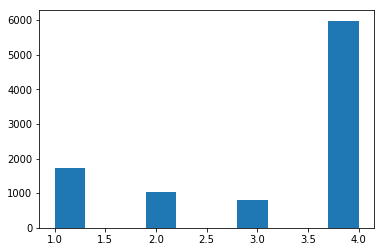

In [75]:
plt.hist(test)

# Time for AdaBoost

In [59]:
def scoring(data1,data2):
    if len(data1) != len(data2):
        raise ValueError("Not the same length man")
    print("Percent Correct: ", (data1 == data2).sum()/len(data1) )

In [57]:
ADA = AdaBoostClassifier(random_state=3)
ADA.fit(X_train,y)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=3)

In [58]:
# get them predictions
poverty_submission2_model_predicitons = ADA.predict(X_test)
poverty_submission2 = pd.DataFrame()
poverty_submission2['Id'] = test_ID
poverty_submission2['Target'] = poverty_submission2_model_predicitons
poverty_submission2.to_csv('poverty_submission2.csv',index=False)

In [70]:
preds = ADA.predict(X_train)
score_it = classification_report(preds, y)
print(score_it)

              precision    recall  f1-score   support

           1       0.31      0.50      0.39       475
           2       0.37      0.41      0.39      1443
           3       0.01      0.34      0.03        53
           4       0.92      0.73      0.82      7586

   micro avg       0.67      0.67      0.67      9557
   macro avg       0.41      0.49      0.40      9557
weighted avg       0.81      0.67      0.73      9557



(array([ 475.,    0.,    0., 1443.,    0.,    0.,   53.,    0.,    0.,
        7586.]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <a list of 10 Patch objects>)

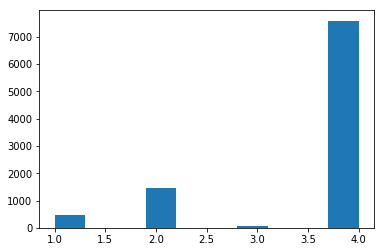

In [74]:
plt.hist(preds)

## Well, unfortunately I don't have more time to do this but I did learn a lot

Overall I learned how to do grid search cv and that was something I've been wanting to mess with and learn. Furthermore, selection was limited by time, as submissions were definitely not my friend on this assignment as they were much more tricky through the terminal. 
Usefulness- Honestly, this model is not very useful. I need to correct for the fact that our data is so skewed towards predicting 4, where it needs to think that every possibility is likely. Looking at the scores the mdoel got in the end, I think they scored based on having a fairly even distribution on the test set, an interesting mentatlity for scoring. Unfortunately this makes it difficult to fit a model as the model should be more liekly to predict the outcome that is more likely, a 4, but the test set is not designed as such.